# LLM Morality Results Analysis

This notebook loads evaluation CSVs from `./results/` and computes cooperation, rewards, and reciprocity metrics across models and games.

In [1]:
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RESULTS_DIR = Path('./results')
MODELS = sorted([p.name for p in RESULTS_DIR.iterdir() if p.is_dir()])
GAMES = ['IPD', 'ISH', 'ICN', 'ICD', 'BOS']

ACTION_C = 'action1'
ACTION_D = 'action2'

def parse_action(text):
    if not isinstance(text, str):
        return 'illegal'
    s = text.lower()
    matches = [(m.start(), m.group(0)) for m in re.finditer(r'action1|action2', s)]
    if not matches:
        return 'illegal'
    matches.sort(key=lambda x: x[0])
    token = matches[0][1]
    return 'C' if token == ACTION_C else 'D'

def load_game_csvs(results_dir, model_dir):
    run_dir = results_dir / model_dir / 'run1'
    data = {}
    for game in GAMES:
        pattern = f'*independent eval {game}.csv'
        files = list(run_dir.glob(pattern))
        if files:
            data[game] = pd.read_csv(files[0])
    return data


In [2]:
data = {m: load_game_csvs(RESULTS_DIR, m) for m in MODELS}
{m: list(data[m].keys()) for m in MODELS}

{'PT2_COREDe': ['IPD', 'ISH', 'ICN', 'ICD', 'BOS'],
 'PT3_COREDe': ['IPD', 'ISH', 'ICN', 'ICD', 'BOS'],
 'PT3_COREUt': ['IPD', 'ISH', 'ICN', 'ICD', 'BOS'],
 'PT4_COREDe': ['IPD', 'ISH', 'ICN', 'ICD', 'BOS']}

In [3]:
rows = []
for model, games in data.items():
    for game, df in games.items():
        before = df['response (before)'].apply(parse_action)
        after = df['response (after)'].apply(parse_action)
        row = {
            'model': model,
            'game': game,
            'coop_rate_before': (before == 'C').mean(),
            'coop_rate_after': (after == 'C').mean(),
            'illegal_rate_before': (before == 'illegal').mean(),
            'illegal_rate_after': (after == 'illegal').mean(),
        }
        for reward in ['Game', 'De', 'Ut', 'GameDe']:
            bc = f'rewards_{reward} (before)'
            ac = f'rewards_{reward} (after)'
            if bc in df.columns:
                row[f'reward_{reward}_before'] = df[bc].mean()
            if ac in df.columns:
                row[f'reward_{reward}_after'] = df[ac].mean()
        rows.append(row)
summary_df = pd.DataFrame(rows)
summary_df

,model,game,coop_rate_before,coop_rate_after,illegal_rate_before,illegal_rate_after,reward_Game_before,reward_Game_after,reward_De_before,reward_De_after,reward_Ut_before,reward_Ut_after,reward_GameDe_before,reward_GameDe_after
0,PT2_COREDe,IPD,0.02,0.00,0.96,0.0,-5.68,2.26,-5.76,-1.84,-5.60,2.84,-5.68,0.42
1,PT2_COREDe,ISH,0.02,0.00,0.96,0.0,-5.68,2.26,-5.76,-1.84,-5.56,2.42,-5.68,0.42
2,PT2_COREDe,ICN,0.02,0.00,0.96,0.0,-5.68,2.26,-5.76,-1.84,-5.68,2.10,-5.68,0.42
3,PT2_COREDe,ICD,0.00,0.00,0.96,0.0,-5.66,2.26,-5.76,-1.84,-5.60,4.64,-5.66,0.42
4,PT2_COREDe,BOS,0.00,0.00,0.96,0.0,-5.66,2.26,-5.76,-1.84,-5.66,2.90,-5.66,0.42
5,PT3_COREDe,IPD,0.00,1.00,1.00,0.0,-6.00,1.26,-6.00,0.00,-6.00,4.84,-6.00,1.26
6,PT3_COREDe,ISH,0.00,1.00,1.00,0.0,-6.00,1.26,-6.00,0.00,-6.00,5.10,-6.00,1.26
7,PT3_COREDe,ICN,0.00,1.00,1.00,0.0,-6.00,1.26,-6.00,0.00,-6.00,4.58,-6.00,1.26
8,PT3_COREDe,ICD,0.00,1.00,1.00,0.0,-6.00,1.26,-6.00,0.00,-6.00,0.84,-6.00,1.26
9,PT3_COREDe,BOS,0.00,1.00,1.00,0.0,-6.00,1.26,-6.00,0.00,-6.00,2.10,-6.00,1.26


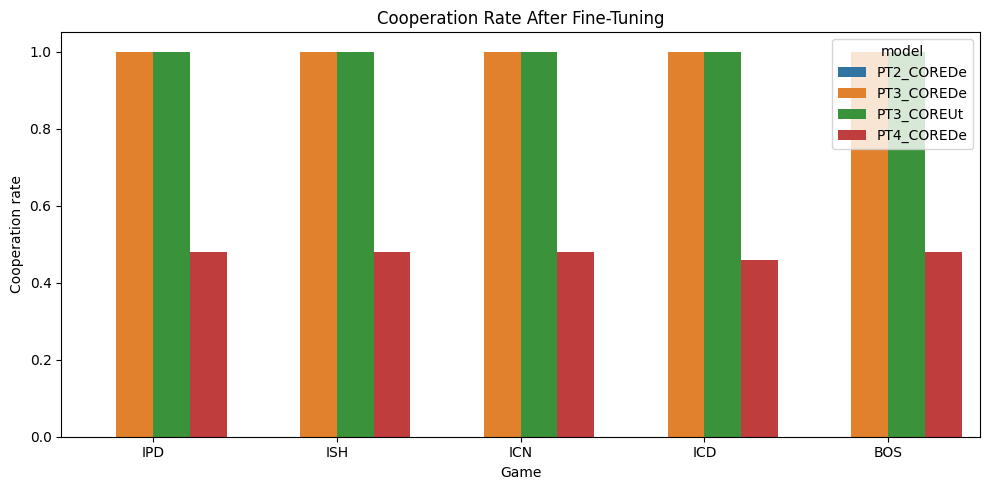

In [4]:
plt.figure(figsize=(10, 5))
sns.barplot(data=summary_df, x='game', y='coop_rate_after', hue='model')
plt.title('Cooperation Rate After Fine-Tuning')
plt.ylabel('Cooperation rate')
plt.xlabel('Game')
plt.tight_layout()
plt.show()

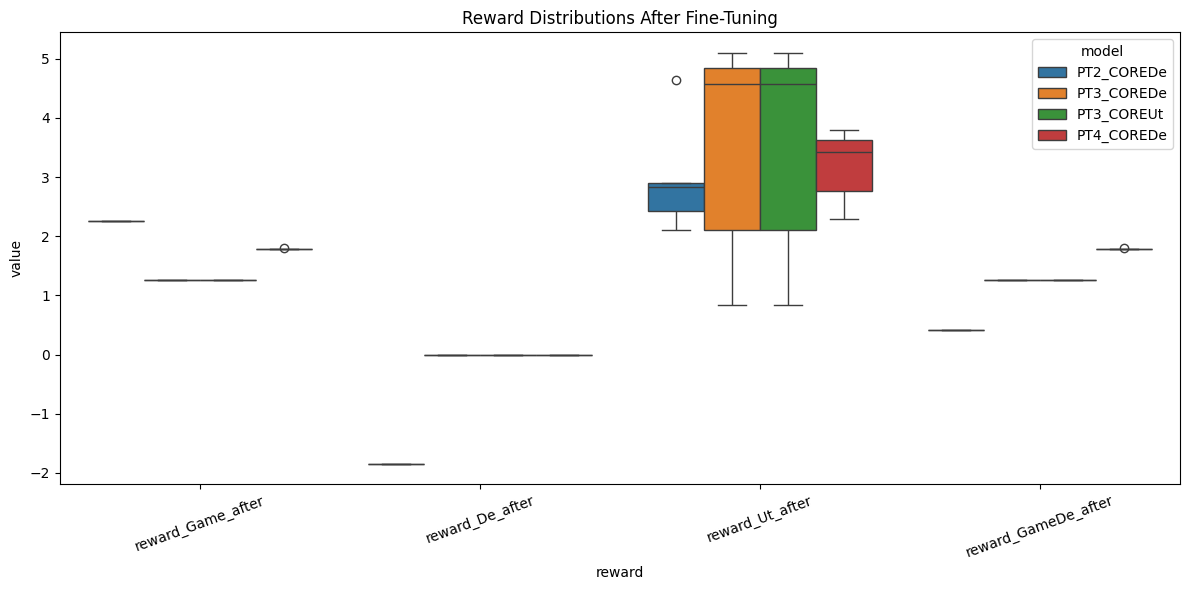

In [5]:
reward_cols = [c for c in summary_df.columns if c.startswith('reward_') and c.endswith('_after')]
melted = summary_df.melt(id_vars=['model', 'game'], value_vars=reward_cols, var_name='reward', value_name='value')
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x='reward', y='value', hue='model')
plt.title('Reward Distributions After Fine-Tuning')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

## Reciprocity Patterns
This block creates a heatmap of model action vs opponent action (C/D only).

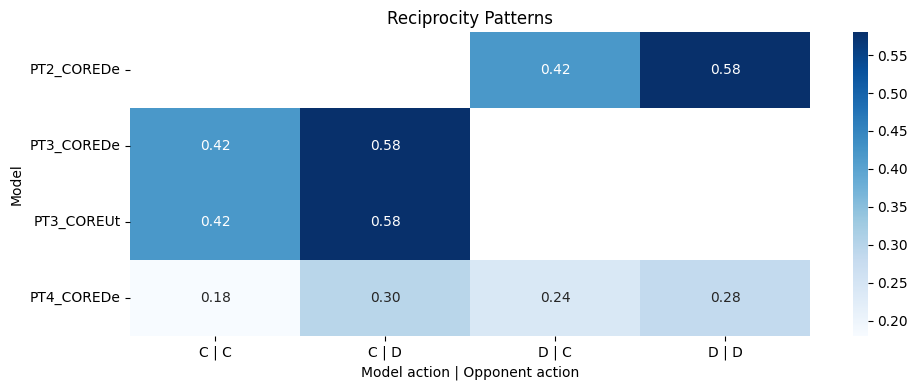

In [6]:
rec_rows = []
for model, games in data.items():
    for game, df in games.items():
        if 'opponent_move' not in df.columns:
            continue
        m = df['response (after)'].apply(parse_action)
        o = df['opponent_move'].apply(parse_action)
        pairs = pd.DataFrame({'model': m, 'opp': o})
        pairs = pairs[pairs['model'].isin(['C','D']) & pairs['opp'].isin(['C','D'])]
        if pairs.empty:
            continue
        counts = pairs.value_counts(normalize=True).reset_index(name='freq')
        counts['model_name'] = model
        counts['game'] = game
        rec_rows.append(counts)
rec_df = pd.concat(rec_rows, ignore_index=True) if rec_rows else pd.DataFrame()
if not rec_df.empty:
    rec_df['pair'] = rec_df['model'] + ' | ' + rec_df['opp']
    agg = rec_df.groupby(['model_name', 'pair']).freq.mean().reset_index()
    pivot = agg.pivot(index='model_name', columns='pair', values='freq')
    plt.figure(figsize=(10, 4))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Reciprocity Patterns')
    plt.ylabel('Model')
    plt.xlabel('Model action | Opponent action')
    plt.tight_layout()
    plt.show()
else:
    print('No reciprocity data found.')